In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pickle import dump
from pickle import load
import joblib
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance 

In [2]:
# Parts上下機資料csv中有中文字,在讀取csv,可設定編碼方式,中文字便可正常顯示 ,參考:https://docs.python.org/3.7/library/codecs.html#standard-encodings
df_Parts = pd.read_csv(r'D:\AI_Parts線邊合理量\07-PreTest\source\Scm_Parts_TrainingData20210407.csv',encoding="big5hkscs" )
df_ori = df_Parts
# df_Tool = pd.read_csv(r'D:\AI_Parts線邊合理量\07-PreTest\source\ScmTrainingData.20210310.csv',encoding="big5hkscs" )
# len(df_Parts)
print(len(df_Parts))
print(df_Parts.columns)


19311
Index(['STOCK_EVENT_TIME', 'PART_NO', 'CATEGORY', 'PUT_ON_SERIAL',
       'REPLACE_SERIAL', 'EQP_NO', 'CHAMBER_NO', 'LAYER', 'PUT_ON_STATUS',
       'REPLACE_STATUS', 'KIND', 'FAB', 'QTY'],
      dtype='object')


# 2.取2016/1/1起的 TMS Parts上下機資料


In [3]:
# 85-EMA0130
# 85-EKA0270
# 87-WPT1070
# 85-EMA0900
# 85-ECT0010
# 86-DIA0120
# 85-EKA0190
# 85-EMA0910
# 85-EMA0920


# df_Parts = df_Parts[df_Parts['STOCK_EVENT_TIME']>'2015/12/31']
partno = '85-ECT0010'
df_Parts = df_Parts[df_Parts['PART_NO'] == partno]

# print(df_Parts)
# print(len(df_Parts))

#顯示每月
df_sum = df_Parts
df_sum['STOCK_EVENT_TIME'] = pd.to_datetime(df_sum['STOCK_EVENT_TIME'],format="%Y/%m/%d")
df_sum['YM'] = df_sum['STOCK_EVENT_TIME'].dt.strftime('%Y')+df_sum['STOCK_EVENT_TIME'].dt.strftime('%m')
# print(df_sum)

df_sum_month =df_sum.set_index('STOCK_EVENT_TIME').groupby(['PART_NO'])['QTY'].resample('M').sum()
df_sum_month =df_sum_month.reset_index()

print(df_sum_month)

# plt.plot(df_sum_month['STOCK_EVENT_TIME'],df_sum_month['QTY'])
# plt.show()

# df_sum_monthFab =df_sum.set_index('STOCK_EVENT_TIME').groupby(['PART_NO','FAB'])['QTY'].resample('M').sum()
# df_sum_monthFab =df_sum_monthFab.reset_index()

  

ipykernel_launcher:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
       PART_NO STOCK_EVENT_TIME  QTY
0   85-ECT0010       2015-10-31  146
1   85-ECT0010       2015-11-30  167
2   85-ECT0010       2015-12-31  169
3   85-ECT0010       2016-01-31  168
4   85-ECT0010       2016-02-29  144
..         ...              ...  ...
61  85-ECT0010       2020-11-30  227
62  85-ECT0010       2020-12-31  232
63  85-ECT0010       2021-01-31  240
64  85-ECT0010       2021-02-28  220
65  85-ECT0010       2021-03-31  240

[66 rows x 3 columns]
ipykernel_launcher:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [4]:
# https://medium.com/2018%E6%88%91%E5%9C%A8tibame-%E6%88%91%E7%9A%84ai%E8%8F%81%E8%8B%B1%E4%B9%8B%E8%B7%AF/%E4%BD%BF%E7%94%A8xgboost%E5%AF%A6%E4%BD%9C%E8%82%A1%E5%83%B9%E9%A0%90%E6%B8%AC-6f60916b828f

In [5]:
print(df_Parts.columns)

Index(['STOCK_EVENT_TIME', 'PART_NO', 'CATEGORY', 'PUT_ON_SERIAL',
       'REPLACE_SERIAL', 'EQP_NO', 'CHAMBER_NO', 'LAYER', 'PUT_ON_STATUS',
       'REPLACE_STATUS', 'KIND', 'FAB', 'QTY', 'YM'],
      dtype='object')


In [6]:

#使用 resample(M:時間序列資料產生頻率以月為單位) By月產生 料號-機台-日期(每月月底) -PM-TS-QTY 的Parts彙總資料
 
df_his=df_Parts.drop(columns=['YM','FAB'])
# print(df_his.columns)
# print(df_his)
#print("----------------------------------------------------")
append_df=pd.DataFrame({"PART_NO":[partno,partno],'QTY':[0,0]},index=[pd.to_datetime('2015-01-01'),pd.to_datetime('2021-03-31')])
# print (append_df)
#print("----------------------------------------------------")

#設定df_union的Shape同df_his
df_union = append_df.reset_index()
df_union = df_union.rename(columns={'index':'STOCK_EVENT_TIME'})
df_union = df_union.reindex(columns = df_his.columns)
# print (df_union)
#print("----------------------------------------------------")


#df_new =df_his Union df_union
df_new =  df_his.append(df_union)
df_new =  df_new.sort_values('STOCK_EVENT_TIME')

# 使用get_dummies >> df_new.KIND ,展開產生PM ,TS,ENG,NST欄位
df_new =  df_new.join(pd.get_dummies(df_ori.KIND))

#Drop 欄位:KIND 
df_new=df_new.drop(columns=['KIND'])

# 回填 每筆 紀錄的 PM ,TS,ENG,NST 實際數量
df_new['PM'] = df_new['QTY']*df_new['PM']
df_new['TS'] = df_new['QTY']*df_new['TS']
df_new['ENG'] = df_new['QTY']*df_new['ENG']
df_new['NST'] = df_new['QTY']*df_new['NST']


df_new.columns
#對QTY,PM,TS,ENG,NST 欄位  By月進行加總
df_month = df_new.copy()
df_month = df_month.set_index('STOCK_EVENT_TIME').groupby(['PART_NO','EQP_NO'])[['QTY','PM','TS','ENG','NST']].resample('M').sum()
df_month =df_month.reset_index()

# df_month.to_csv('../data/Parts_Output_ByMonth_20210406_85-ECT0010.csv',encoding="utf_8_sig" , index = False)


In [7]:
list_eqp = df_month.reset_index()['EQP_NO'].unique().tolist()
# list_eqp

In [8]:
df_concat = pd.DataFrame()  
df_sub = dict()
for eqp in  list_eqp:
    df_sub[eqp] = df_month[df_month['EQP_NO']==eqp]
    df_append =pd.DataFrame({
           "EQP_NO":[eqp,eqp],
           'QTY':[0,0],
           'PM':[0,0],
           'ENG':[0,0],
           'NST':[0,0]
          }, index=[pd.to_datetime('2015-01-01'),pd.to_datetime('2021-03-31')])
    df_append = df_append.reset_index()
    # print(df_append)
    df_append = df_append.rename(columns={'index':'STOCK_EVENT_TIME'})
    df_combine = df_sub[eqp].append(df_append)
    # print(df_combine)
    df_sample = df_combine.set_index('STOCK_EVENT_TIME').groupby(['EQP_NO']).resample('M').sum().reset_index()
    df_sample.insert(0,column='PART_NO',value=partno)    
    df_concat = df_concat.append(df_sample,ignore_index=True)

# temp_path ='../data/Parts_EQP_Output_0409_'+partno+'.csv'
# df_concat.to_csv(temp_path  , index = False)
   

In [9]:
# df_concat[STOCK_EVENT_TIME]格式轉換成YYYYMM
df_concat['STOCK_EVENT_TIME'] =  (df_concat['STOCK_EVENT_TIME'].dt.strftime('%Y')+df_concat['STOCK_EVENT_TIME'].dt.strftime('%m')).astype(str)
df_concat

,PART_NO,EQP_NO,STOCK_EVENT_TIME,QTY,PM,TS,ENG,NST
0,85-ECT0010,ECT11,201501,0,0,0.0,0,0
1,85-ECT0010,ECT11,201502,0,0,0.0,0,0
2,85-ECT0010,ECT11,201503,0,0,0.0,0,0
3,85-ECT0010,ECT11,201504,0,0,0.0,0,0
4,85-ECT0010,ECT11,201505,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...
3145,85-ECT0010,EUT61,202011,7,7,0.0,0,0
3146,85-ECT0010,EUT61,202012,6,6,0.0,0,0
3147,85-ECT0010,EUT61,202101,7,7,0.0,0,0
3148,85-ECT0010,EUT61,202102,4,4,0.0,0,0


In [10]:
# Merge  Parts彙總資料:df_month & 機台資訊:df_toolid (From kimbal)
df_toolid = pd.read_csv(r'D:\AI_Parts線邊合理量\07-PreTest\source\ScmTrainingData_Monthly_30days.csv')
df_toolid= df_toolid.rename(columns=
                        { 'MFG_MONTH':'STOCK_EVENT_TIME',
                          'TOOL_ID':'EQP_NO'})
df_toolid['STOCK_EVENT_TIME'] =df_toolid['STOCK_EVENT_TIME'].astype(str)
# df_toolid.info()

df_toolid = df_toolid.drop(columns=['M_NUM','C_UP_TIME','LOT_SIZE','C_LOT_SIZE','C_EQP_UTIL','PROCESS_JOBTIME',
                                    'INLINE_CT_LOT','INLINE_CT_WAFER','C_TC','ENG_LOT_RATE','HOT_LOT_RATE',
                                    'BACKUP_BY_RATE','BACKUP_FOR_RATE','RWORK_LOT_RATE','QUE_LOT_RATE',
                                     'SAMPLING_RATE'
                                    ])


df_merge = df_concat.merge(df_toolid, on=['STOCK_EVENT_TIME','EQP_NO'], how='left')
df_merge = df_merge.loc[ (df_merge['STOCK_EVENT_TIME'] >'202001') & (df_merge['STOCK_EVENT_TIME'] <'202104')] 
df_merge =  df_merge.sort_values('STOCK_EVENT_TIME')
# df_merge.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 588 entries, 61 to 3149
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PART_NO           588 non-null    object 
 1   EQP_NO            588 non-null    object 
 2   STOCK_EVENT_TIME  588 non-null    object 
 3   QTY               588 non-null    int64  
 4   PM                588 non-null    int64  
 5   TS                588 non-null    float64
 6   ENG               588 non-null    int64  
 7   NST               588 non-null    int64  
 8   UP_TIME           574 non-null    float64
 9   EQP_UTIL          574 non-null    float64
 10  EQP_AVAIL_RATE    574 non-null    float64
 11  TC                573 non-null    float64
 12  PROCESS_TIME      574 non-null    float64
 13  MOVE_QTY          574 non-null    float64
 14  NUM_RECIPE        574 non-null    float64
 15  CHANGE_RECIPE     574 non-null    float64
dtypes: float64(9), int64(4), object(3)
memory 

In [11]:
# Tarining data 資料範圍 : 2020/02~2020/12
# Testing Data  資料範圍 : 2021/01~2021/02 

df_train = df_merge.loc[(df_merge['STOCK_EVENT_TIME']>'202001') & (df_merge['STOCK_EVENT_TIME']<'202101')] 
df_test  = df_merge.loc[(df_merge['STOCK_EVENT_TIME']>'202012') & (df_merge['STOCK_EVENT_TIME']<'202104')] 

df_train =  df_train.sort_values(['PART_NO','STOCK_EVENT_TIME'])
df_test =  df_test.sort_values(['PART_NO','STOCK_EVENT_TIME'])

del_cols=['PM','TS','ENG','NST','STOCK_EVENT_TIME']

df_train = df_train.drop(columns = del_cols, axis=1)
df_test  = df_test.drop(columns = del_cols, axis=1)
# df_train
# df_test

In [12]:
def preHandleData(df,isTrain=True):
    from sklearn.preprocessing import StandardScaler #平均&變異數標準化 平均值為0，方差為1。
    from sklearn.preprocessing import MinMaxScaler #最小最大值標準化[0,1]
    from sklearn.preprocessing import RobustScaler #中位數和四分位數標準化
    from sklearn.preprocessing import MaxAbsScaler #絕對值最大標準化

    target_cols=['QTY'] 
    
    # cat_cols :Category欄位資料
    cat_cols = ['PART_NO','EQP_NO']
    
    #num_cols :數值欄位資料
    num_cols =[e for e in df.columns.to_list() if e not in cat_cols+target_cols]
    
    #==================================================
    # 1. 缺漏值填空
    #==================================================
    # df = df.fillna(df.median())
    df = df.fillna(0)
    #==================================================
    # 2.特徵縮放
    #==================================================
    df_scale = df.copy(deep=False)
    global df_cols
    df_cols = df_scale.columns

    # print(df_cols)

    if isTrain:
        scaler = MinMaxScaler()
        scaler.fit(df[num_cols])
        df_scale[num_cols]= scaler.transform(df_scale[num_cols])
        dump(scaler, open('scaler.pkl', 'wb'))
    else:
        # load the scaler
        scaler = load(open('scaler.pkl', 'rb'))
        df_scale[num_cols] = scaler.transform(df[num_cols])   
        
    global df_dummy_ori
    df_dummy =pd.get_dummies(df_scale.drop(target_cols, axis=1),columns=cat_cols)
    # save the scaler

    #==================================================
    # 3.one hot encoder
    #==================================================
    if isTrain:
        df_dummy_ori = df_dummy.copy(deep=False)
    else:
        df_dummy = df_dummy.reindex(columns = df_dummy_ori.columns, fill_value=0)

    # print(df_dummy)
    
    df_scale.to_csv('./df_scale.csv')
           
    X_dropped = np.asarray(df_dummy)
    Y_dropped = np.asarray(df[target_cols]) 

    return X_dropped,Y_dropped



In [13]:
# https://codertw.com/%E7%A8%8B%E5%BC%8F%E8%AA%9E%E8%A8%80/468132/
def trainXG(df):    
    import xgboost as xgb    
    X,Y = preHandleData(df,True)

   #拆分train validation set
    X_train, X_test,y_train,y_test = train_test_split(X,Y,test_size =0.2,random_state=888)
    
    # other_params = {'learning_rate': 0.1, 'n_estimators': 200, 'max_depth': 5, }
    # model = xgb.XGBRegressor(**other_params)
    model = xgb.XGBRegressor()
    bst_model= model    
    
    bst_model.fit(X_train, y_train)
    # plot_importance(bst_model)#,max_num_features=10)
    # plt.show()

    joblib.dump(bst_model, 'XG_model')


In [14]:
def testXG(df):
    X_test,y_test = preHandleData(df,False)
    # print(X_test)
    # print(X_test,y_test)
    df_result = df.copy(deep=True)
    loaded_model = joblib.load('XG_model')
    y_predict = loaded_model.predict(X_test)
    df_result['predict'] = y_predict  
    loaded_model.score(X_test, y_test)
    print("XGBoost score:", loaded_model.score(X_test, y_test))
    print('acc:',accsum(df_result))
    
    x_len = np.arange(len(X_test))# 创建t变量
    show_title= 'XGBoost('+partno+')'
    path_xg = './Result/XGtest_'+partno+'.png'
    # drawModelResult('XGBoost','',x_len,y_test, y_predict,'./Result/XGtest.png')
    drawModelResult(show_title,'',x_len,y_test, y_predict,path_xg)
    
    return df_result


In [15]:
def accsum(def_result,target_col='QTY'):
    _accsum=0
    def_result[def_result[target_col] ==0.0][target_col]  =0.0001
    def_result[def_result['predict'] <0]['predict']  =0
    for index,row in def_result.iterrows():
        if row[target_col] <0 :
            row[target_col]  =0.00001
        if row[target_col] ==0.0:
            row[target_col]  =0.00001
        # print(row['TRCT'] )
        if 1- abs((row['predict'] - row[target_col])/row[target_col] ) >0 :
            
            _accsum+=(1- abs((row['predict'] - row[target_col])/row[target_col] ))
    
    return _accsum/def_result.shape[0]

In [16]:
def drawModelResult(modelType,desc,x_len,y_actual,y_predict ,imagepath):

    plt.figure(figsize=(20, 5))# 圖片尺寸
    plt.title(modelType)
    plt.ylabel("UseQty")    

    plt.plot(x_len,y_actual ,label = "Actual", color='blue', marker='.',linewidth = '0.5')
    plt.plot(x_len,y_predict, label = "Predict ", color='red', marker='.',linewidth = '0.5')
    plt.legend()
    plt.savefig(imagepath)


In [17]:
print("df_train 資料筆數:", df_train.shape[0])
print("df_test 資料筆數:", df_test.shape[0])

df_train 資料筆數: 462
df_test 資料筆數: 126


In [18]:
print('-----RUN XGBOOST train------')
df_train
trainXG(df_train)

-----RUN XGBOOST train------


-----RUN XGBOOST test------
XGBoost score: 0.7019923250276803
acc: 0.8093775370554108
ipykernel_launcher:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


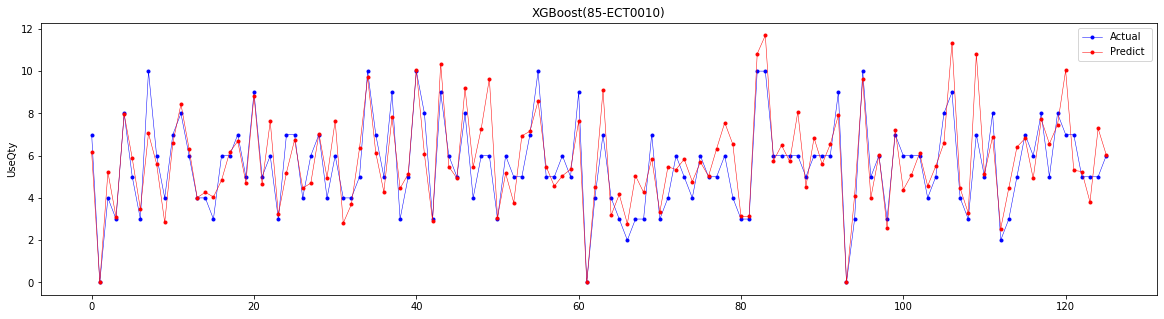

In [19]:
print('-----RUN XGBOOST test------')
df_xg_result = testXG(df_test)
# print(df_xg_result.head())


In [20]:
def trainNN(df):
    import tensorflow as tf
    save_model_tool = './NN/training_model.h5'

    df_result = df.copy(deep=False)
    X_dropped, Y_dropped = preHandleData(df_result,True)
    
    #建立模型
    # 1.建立model :使用Sequential model 
    # 將Layer放入Model中 (使用keras.layers.Dropout 防止過度擬合 ex:Dropout(0.2)隨機拋棄20%的數據(0-1之間) )
    # input_shape:N (N維向量)
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=16,input_shape=[X_dropped.shape[1]]), # units：输出维度      
        tf.keras.layers.Dense(units=16, kernel_initializer='random_uniform', activation='relu'),      
        tf.keras.layers.Dense(units=1, kernel_initializer='random_uniform',activation='relu') ])   

    # 以complie函數定義 損失函數(loss),優化函數(optimizer) 及成效衡量指標(metrics)
    # 損失函數(loss) : mse(mean_squared_error) ,categorical_crossentropy,binary_crossentropy,mean_absolute_error
    # kernel_initializer:權重的初始值(初始值的選擇會影響優化結果)
    # verbose=2:每個epoch輸出一行紀錄
    # epochs :訓練輪數
    # batch_size:每個batch包含的樣本數

    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01) )    
    # train_history = model.fit(x=X_dropped, y=Y_dropped, validation_split=0.10, epochs=100, batch_size=100, verbose=0) 
    train_history = model.fit(x=X_dropped, y=Y_dropped, validation_split=0.10, epochs=100, batch_size=25, verbose=0) 
    model.save(save_model_tool)

    plt.plot(train_history.history['loss'], label = 'train')
    plt.plot(train_history.history['val_loss'], label = 'validation')
    plt.title(partno +" train loss vs validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.show()
    
    

In [21]:
def testNN(df):
    import tensorflow as tf
    save_model_tool = './NN/training_model.h5'
    model = tf.keras.models.load_model(save_model_tool)
    df_result=df.copy(deep=True)

    X_test,Y_test = preHandleData(df,False)
    y_predict = model.predict(X_test)
    df_result['predict'] = y_predict  # 預測
    print('acc:',accsum(df_result))
    x_len = np.arange(len(X_test)) 

    show_title= 'NN('+partno+')'
    path_nn = './Result/NNtest_'+partno+'.png'
    # drawModelResult('NN','',x_len,Y_test, y_predict,'./Result/NNtest.png')    
    drawModelResult(show_title,'',x_len,Y_test, y_predict,path_nn)    
    return df_result



In [ ]:
print('==============================')
print('-----RUN NN train------')
trainNN(df_train)

In [ ]:
print('-----RUN NN test------')
df_NN_result =testNN(df_test)
# print(df_NN_result.head())